This notebook describes the data from the **Recommendations with IBM** materials.
<br>
It concerns the use of the platform `to_complete` by its users.
<br>

In the following we'll define the _activities_ or _interactions_ every interaction of a user with an article. This means that if a user reads the articles with ids 5, 12, 104 respectively 2, 3 and 1 times, the number of activities of the user is 2 + 3 + 1 = 6.
<br>
On the other hand, we'll define _readings_ as the number of unique article read. Taking into account the previous example, the number of reading will be 3.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('seaborn')

from recommendations_with_IBM.analysis import users as pu
from recommendations_with_IBM.read_data import reader

fig_args = {'figsize': (18, 6),
           'new_figure': 1}

# Loading data
in this section we load the data in a pandas.DataFrame and clean them.
<br>
Original data has columns ```['article_id', 'title', 'email']``` with some NaN value for the 'email' field.
<br>
We clean the NaN value and then assign to each email a integer 'user_id' for simplification.

In [13]:
u = reader.UserList()
df = u.df
df.head()

,article_id,title,email,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,3887
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,3684
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,2005
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,1636
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,4090


In [14]:
n_entries, _ = df.shape
print(f'The table has {n_entries} entries')
n_user = len(df.user_id.unique())
print(f'Number of users: {n_user}')

The table has 45976 entries
Number of users: 5148


# I. Explanatory Data Analysis
Before making recommendations of any kind, you will need to explore the data you are working with for the project.
Dive in to see what you can find.
There are some basic, required questions to be answered about the data you are working with throughout the rest of the
notebook. Use this space to explore, before you dive into the details of your recommendation system in the later
sections.

We have many users but most of them have really few interactions, as shown in the following figure.

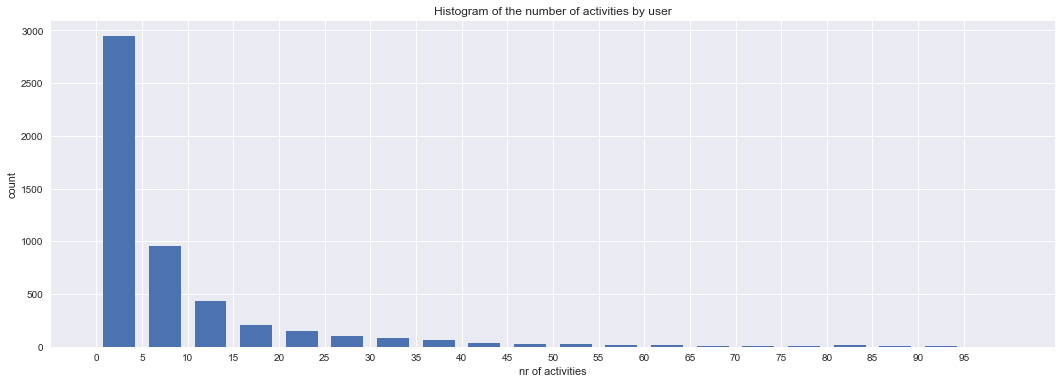

In [15]:
pu.plot_user_activities_histogram(**fig_args)
plt.xticks(np.arange(0, 100, 5));
plt.xlim(-5, 105);

_Figure: histogram of the number of interactions of the users. Nearly 4000 users (over a total of 5148) have less than 10 interactions_

More or less, the same happes for the number of article read by the users.

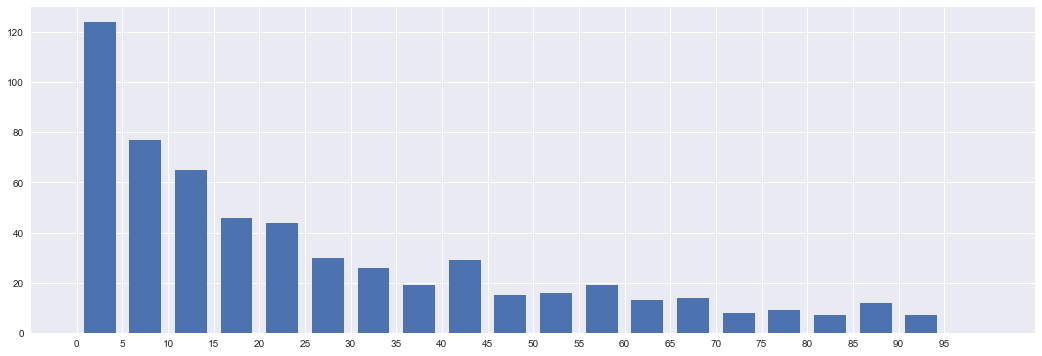

In [10]:
pu.plot_article_readings_histogram(**fig_args)
plt.xticks(np.arange(0, 100, 5));
plt.xlim(-5, 105);
plt.grid(True)

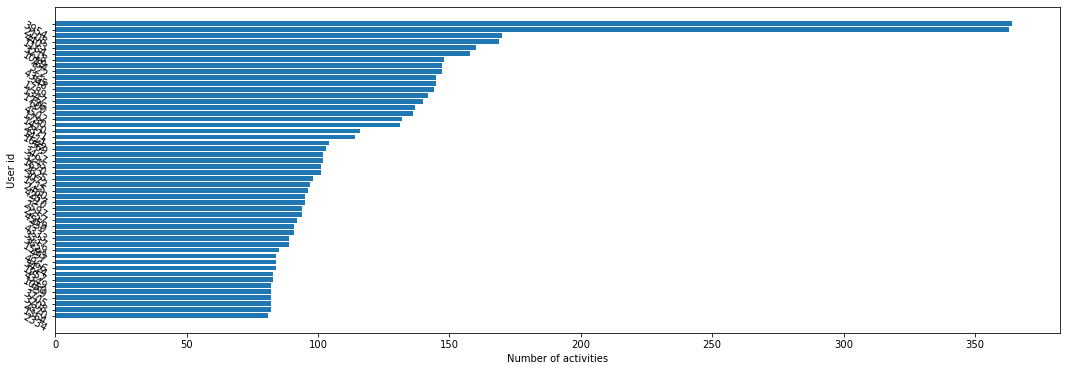

In [23]:
pu.plot_user_activities(**fig_args)

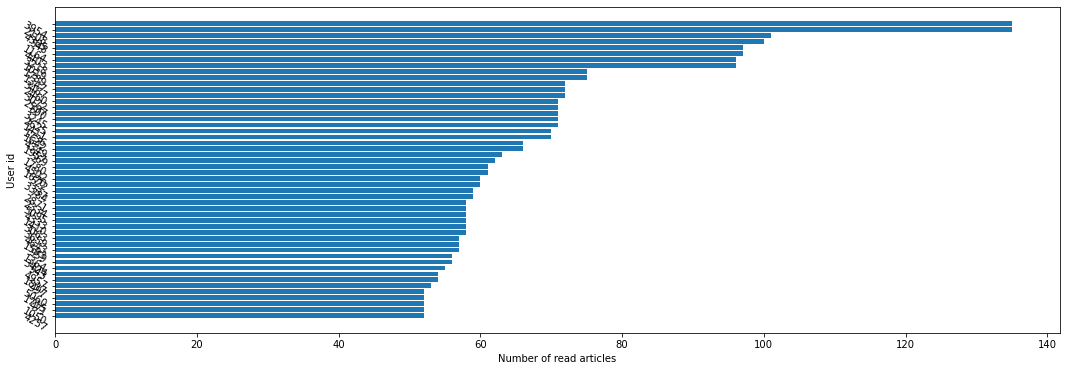

In [24]:
pu.plot_user_articles(**fig_args)